# <center> <b> <font color='blue'> Windowing a dataset </center> </b> </font>


## <font color='#1f618d'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Univariate Time Series Windowing](#3)<br>
   3.1. [Generating Data](#3.1) <br>
   3.2. [Using TF](#3.2) <br>
   3.3. [Using Pandas](#3.3)
4. [Multivariate Time Series Windowing](#4) <br>
   4.1. [Generating Data](#4.1) <br>
   4.2. [Using TF](#4.2) <br>
   4.3. [Using Pandas](#4.3)
5. [Summary](#5)
6. [References](#References)

<a name="1"></a>
## <font color='#1f618d'> <b> 1. Introduction </font> </b>

Windowing a dataset is used to convert a time series problem into a supervised learning problem.

We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

<a name="2"></a>
## <font color='#1f618d'> <b> 2. Setup </font> </b>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

<a name="3"></a>
## <font color='#1f618d'> <b> 3. Univariate Time Series Windowing </font> </b>

<a name="3.1"></a>
### <font color='#2874a6'> <b> 3.1. Generating data </font> </b>


In [2]:
# Create a simple time series dataset: numbers from 0 to 20
series = np.arange(21)  # Generate numbers from 0 to 20
time = np.arange(len(series))  # Time index

In [3]:
series

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

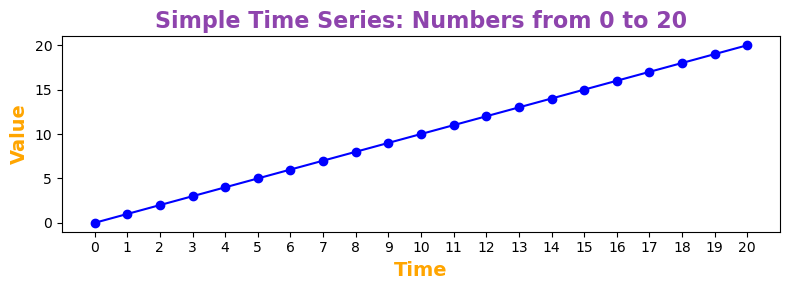

In [4]:
# Plot the data
plt.figure(figsize=(8, 3))
plt.plot(time, series, marker='o', color='blue', linestyle='-')
plt.title('Simple Time Series: Numbers from 0 to 20', fontsize=16, fontweight='bold', color='#8e44ad')
plt.xlabel('Time', fontsize=14, fontweight='bold', color='orange')
plt.ylabel('Value', fontsize=14, fontweight='bold', color='orange')
plt.xticks(time)  # Set x-ticks to be the same as the time values for clarity
#plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
plt.show()

<a name="3.2"></a>
### <font color='#2874a6'> <b> 3.2. Using TensorFlow </font> </b>

In [5]:
horizon = 1
window_size = 3

In [6]:
def windowed_dataset(series, 
                     window_size=3, 
                     horizon=1, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    # w[:-horizon]: all but the last 'horizon' elements for features
    # w[-horizon:]: the last 'horizon' elements for labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))  # Use -horizon for labels
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(1)
    return ds



In [7]:
ds = tf.data.Dataset.from_tensor_slices(series) # convert to a tensor
type(ds)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [8]:
# Create windows of size (window_size + horizon)
ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)

for window_dataset in ds:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 7 
5 6 7 8 
6 7 8 9 
7 8 9 10 
8 9 10 11 
9 10 11 12 
10 11 12 13 
11 12 13 14 
12 13 14 15 
13 14 15 16 
14 15 16 17 
15 16 17 18 
16 17 18 19 
17 18 19 20 


2025-06-27 15:51:02.472915: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [9]:
# Flatten the windows into batches
ds = ds.flat_map(lambda w: w.batch(window_size + horizon))

for window in ds:
    print(window.numpy())

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]
[3 4 5 6]
[4 5 6 7]
[5 6 7 8]
[6 7 8 9]
[ 7  8  9 10]
[ 8  9 10 11]
[ 9 10 11 12]
[10 11 12 13]
[11 12 13 14]
[12 13 14 15]
[13 14 15 16]
[14 15 16 17]
[15 16 17 18]
[16 17 18 19]
[17 18 19 20]


In [10]:
ds = ds.shuffle(20)

for window in ds:
    print(window.numpy())

[12 13 14 15]
[17 18 19 20]
[10 11 12 13]
[3 4 5 6]
[13 14 15 16]
[ 9 10 11 12]
[15 16 17 18]
[11 12 13 14]
[0 1 2 3]
[4 5 6 7]
[14 15 16 17]
[6 7 8 9]
[ 8  9 10 11]
[1 2 3 4]
[ 7  8  9 10]
[16 17 18 19]
[5 6 7 8]
[2 3 4 5]


In [11]:
# Split the windows into features and labels
# w[:-horizon]: all but the last 'horizon' elements for features
# w[-horizon:]: the last 'horizon' elements for labels
ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))  # Use -horizon for labels

for x, y in ds:
    print(f"X: {x.numpy()}  Y: {y.numpy()}")

X: [10 11 12]  Y: [13]
X: [ 9 10 11]  Y: [12]
X: [0 1 2]  Y: [3]
X: [15 16 17]  Y: [18]
X: [13 14 15]  Y: [16]
X: [14 15 16]  Y: [17]
X: [2 3 4]  Y: [5]
X: [17 18 19]  Y: [20]
X: [1 2 3]  Y: [4]
X: [4 5 6]  Y: [7]
X: [6 7 8]  Y: [9]
X: [ 8  9 10]  Y: [11]
X: [11 12 13]  Y: [14]
X: [16 17 18]  Y: [19]
X: [12 13 14]  Y: [15]
X: [3 4 5]  Y: [6]
X: [5 6 7]  Y: [8]
X: [7 8 9]  Y: [10]


In [12]:
#  prepare the dataset for efficient training or evaluation by batching the data and 
# optimizing the input pipeline. 
batch_size = 32

ds = ds.batch(batch_size).prefetch(1)

for x,y in ds:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[17 18 19]
 [ 0  1  2]
 [ 6  7  8]
 [ 2  3  4]
 [12 13 14]
 [16 17 18]
 [ 5  6  7]
 [11 12 13]
 [ 1  2  3]
 [ 9 10 11]
 [14 15 16]
 [10 11 12]
 [ 8  9 10]
 [ 7  8  9]
 [ 3  4  5]
 [15 16 17]
 [13 14 15]
 [ 4  5  6]]
y =  [[20]
 [ 3]
 [ 9]
 [ 5]
 [15]
 [19]
 [ 8]
 [14]
 [ 4]
 [12]
 [17]
 [13]
 [11]
 [10]
 [ 6]
 [18]
 [16]
 [ 7]]


We can put everything together in a single function:

In [13]:
def windowed_dataset(series, 
                     window_size=3, 
                     horizon=1, 
                     batch_size=32, 
                     shuffle_buffer=10,
                     shuffle=True):
    
    # Create the dataset from the series
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create windows of size (window_size + horizon)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Flatten the windows into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Split the windows into features and labels
    # w[:-horizon]: all but the last 'horizon' elements for features
    # w[-horizon:]: the last 'horizon' elements for labels
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:]))  # Use -horizon for labels
    
    # Batch the dataset
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [14]:
dataset = windowed_dataset(series, window_size=3, horizon=1)

for x, y in dataset:
    print(x, y)

tf.Tensor(
[[ 7  8  9]
 [10 11 12]
 [ 2  3  4]
 [ 8  9 10]
 [ 0  1  2]
 [11 12 13]
 [13 14 15]
 [16 17 18]
 [ 9 10 11]
 [17 18 19]
 [15 16 17]
 [ 4  5  6]
 [14 15 16]
 [ 6  7  8]
 [ 5  6  7]
 [ 3  4  5]
 [12 13 14]
 [ 1  2  3]], shape=(18, 3), dtype=int64) tf.Tensor(
[[10]
 [13]
 [ 5]
 [11]
 [ 3]
 [14]
 [16]
 [19]
 [12]
 [20]
 [18]
 [ 7]
 [17]
 [ 9]
 [ 8]
 [ 6]
 [15]
 [ 4]], shape=(18, 1), dtype=int64)


Let's test this function with a different window size and a larger horizon:

In [15]:
dataset = windowed_dataset(series, window_size=3, horizon=2)

for x, y in dataset:
    print(x, y)


tf.Tensor(
[[ 7  8  9]
 [ 8  9 10]
 [11 12 13]
 [ 5  6  7]
 [10 11 12]
 [ 3  4  5]
 [12 13 14]
 [14 15 16]
 [ 2  3  4]
 [ 1  2  3]
 [ 0  1  2]
 [ 9 10 11]
 [16 17 18]
 [15 16 17]
 [13 14 15]
 [ 6  7  8]
 [ 4  5  6]], shape=(17, 3), dtype=int64) tf.Tensor(
[[10 11]
 [11 12]
 [14 15]
 [ 8  9]
 [13 14]
 [ 6  7]
 [15 16]
 [17 18]
 [ 5  6]
 [ 4  5]
 [ 3  4]
 [12 13]
 [19 20]
 [18 19]
 [16 17]
 [ 9 10]
 [ 7  8]], shape=(17, 2), dtype=int64)


<a name="3.3"></a>
### <font color='#2874a6'> <b> 3.3. Using Pandas </font> </b>

In [16]:
horizon = 1
window_size = 3

In [17]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    
    Args:
        x (np.ndarray): 2D NumPy array where each row represents a window.
        horizon (int): Number of future time steps to predict.

    Returns:
        tuple: (windows, labels) where windows are the features and labels are the target values.
    """
    return x[:, :-horizon], x[:, -horizon:]

In [18]:
test_window, test_label = get_labelled_windows(tf.expand_dims(series, axis=0), horizon=horizon)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] -> Label: 20


In [19]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.

    Args:
        x (np.ndarray): 1D array of time series data.
        window_size (int): Number of time steps to include in each window.
        horizon (int): Number of future time steps to predict.

    Returns:
        tuple: (windows, labels) where windows are the features and labels are the target values.
    """
    # Check input type
    if not isinstance(x, np.ndarray):
        raise ValueError("Input x must be a NumPy array.")

    # Check input length
    if len(x) < window_size + horizon:
        raise ValueError("Input array must be longer than window_size + horizon.")

    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [20]:
full_windows, full_labels = make_windows(series, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

(18, 18)

In [21]:
for x, y in zip(full_windows, full_labels):
    print(f"Window: {x} | Target: {y}")

Window: [0 1 2] | Target: [3]
Window: [1 2 3] | Target: [4]
Window: [2 3 4] | Target: [5]
Window: [3 4 5] | Target: [6]
Window: [4 5 6] | Target: [7]
Window: [5 6 7] | Target: [8]
Window: [6 7 8] | Target: [9]
Window: [7 8 9] | Target: [10]
Window: [ 8  9 10] | Target: [11]
Window: [ 9 10 11] | Target: [12]
Window: [10 11 12] | Target: [13]
Window: [11 12 13] | Target: [14]
Window: [12 13 14] | Target: [15]
Window: [13 14 15] | Target: [16]
Window: [14 15 16] | Target: [17]
Window: [15 16 17] | Target: [18]
Window: [16 17 18] | Target: [19]
Window: [17 18 19] | Target: [20]


Let's try now with a larger horizon and a different window size:

In [22]:
horizon = 3
window_size = 2

In [23]:
full_windows, full_labels = make_windows(series, window_size=window_size, horizon=horizon)
len(full_windows), len(full_labels)

(17, 17)

In [24]:
for x, y in zip(full_windows, full_labels):
    print(f"Window: {x} | Target: {y}")

Window: [0 1] | Target: [2 3 4]
Window: [1 2] | Target: [3 4 5]
Window: [2 3] | Target: [4 5 6]
Window: [3 4] | Target: [5 6 7]
Window: [4 5] | Target: [6 7 8]
Window: [5 6] | Target: [7 8 9]
Window: [6 7] | Target: [ 8  9 10]
Window: [7 8] | Target: [ 9 10 11]
Window: [8 9] | Target: [10 11 12]
Window: [ 9 10] | Target: [11 12 13]
Window: [10 11] | Target: [12 13 14]
Window: [11 12] | Target: [13 14 15]
Window: [12 13] | Target: [14 15 16]
Window: [13 14] | Target: [15 16 17]
Window: [14 15] | Target: [16 17 18]
Window: [15 16] | Target: [17 18 19]
Window: [16 17] | Target: [18 19 20]


<a name="4"></a>
## <font color='#1f618d'> <b> 4. Multivariate Time Series Windowing </font> </b>

<a name="4.1"></a>
### <font color='#2874a6'> <b> 4.1. Generating data </font> </b>

In [25]:
# Generate a varied multivariate time series dataset
def generate_varied_data(num_samples):
    # Create time steps
    time_steps = np.arange(num_samples)
    
    # Generate random data for temperature, humidity, and pressure
    np.random.seed(0)  # For reproducibility
    humidity = np.random.randint(70, 86, size=num_samples)  # Values between 70 and 85
    temperature = np.random.randint(15, 31, size=num_samples)  # Values between 15 and 30
    
    # Stack features together
    data = np.column_stack((time_steps, humidity, temperature))
    return data

# Generate 10 samples of data
series_multivariate = generate_varied_data(num_samples=10)

series_multivariate

array([[ 0, 82, 20],
       [ 1, 85, 17],
       [ 2, 75, 19],
       [ 3, 70, 22],
       [ 4, 73, 21],
       [ 5, 81, 23],
       [ 6, 73, 23],
       [ 7, 77, 27],
       [ 8, 79, 25],
       [ 9, 73, 16]])

In [26]:
time_steps = series_multivariate[:, 0]
series = series_multivariate[:, 1:] # all execept the first (tempearture and humidity)

We will try to forecast "temperature".

First, let's create some plots to visualize the data.


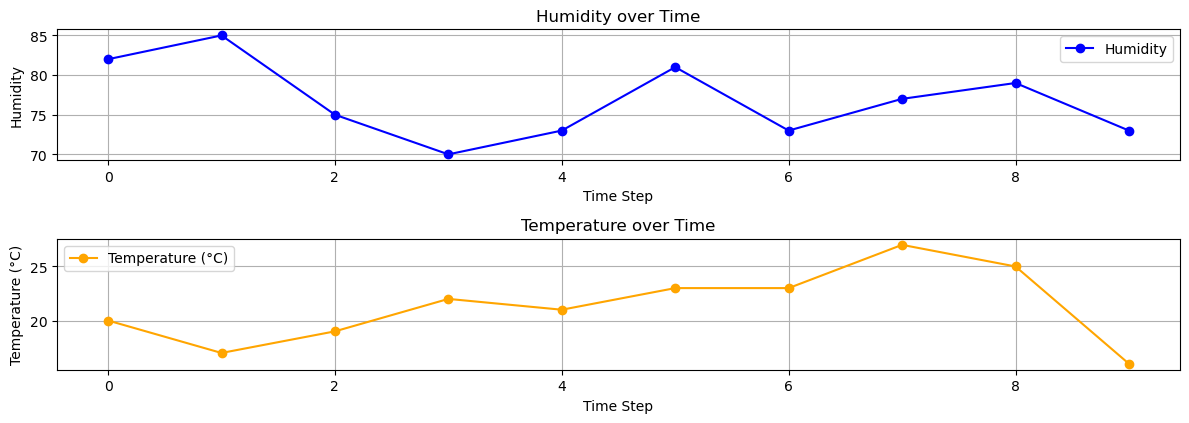

In [33]:
# Extracting time steps, temperature, humidity
humidity = series[:, 0]
temperature = series[:, 1]

# Creating the plots
plt.figure(figsize=(12, 6))

# Plot temperature
plt.subplot(3, 1, 2)
plt.plot(time_steps, temperature, marker='o', color='orange', label='Temperature (°C)')
plt.title('Temperature over Time')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.legend()

# Plot humidity
plt.subplot(3, 1, 1)
plt.plot(time_steps, humidity, marker='o', color='blue', label='Humidity')
plt.title('Humidity over Time')
plt.xlabel('Time Step')
plt.ylabel('Humidity')
plt.grid()
plt.legend()


# Adjust layout
plt.tight_layout()
plt.show()


Let's plot the data in only one plot.

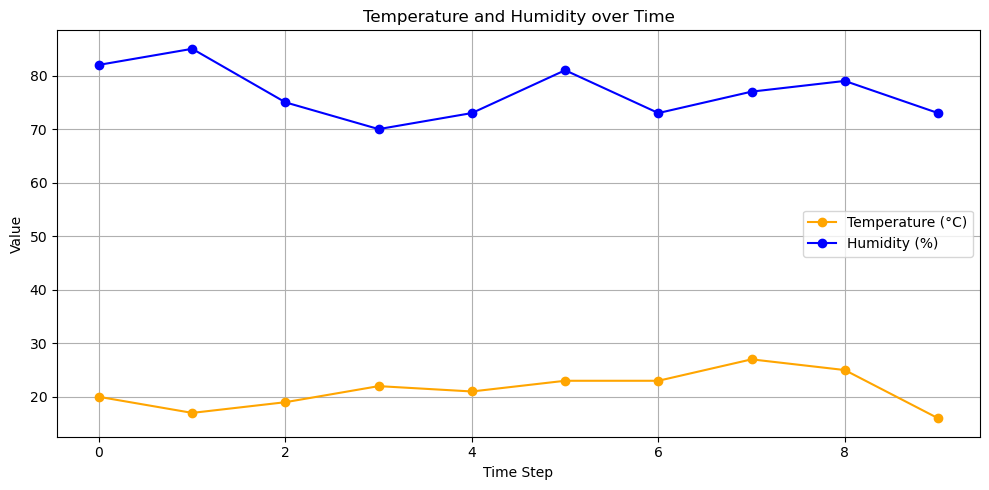

In [34]:
# Creating the plot
plt.figure(figsize=(10, 5))

# Plot temperature
plt.plot(time_steps, temperature, marker='o', color='orange', label='Temperature (°C)')

# Plot humidity (scaled)
plt.plot(time_steps, humidity, marker='o', color='blue', label='Humidity (%)')

# Add title and labels
plt.title('Temperature and Humidity over Time')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid()

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


<a name="4.2"></a>
### <font color='#2874a6'> <b> 4.2. Using TensorFlow </font> </b>

In [35]:
horizon = 1
window_size = 2

In [36]:
# Convert the NumPy array to a TensorFlow Dataset
ds = tf.data.Dataset.from_tensor_slices(series)
type(ds)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [37]:
# Create windows of size (window_size + horizon)
ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

for window_dataset in ds:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[82 20] [85 17] [75 19] 
[85 17] [75 19] [70 22] 
[75 19] [70 22] [73 21] 
[70 22] [73 21] [81 23] 
[73 21] [81 23] [73 23] 
[81 23] [73 23] [77 27] 
[73 23] [77 27] [79 25] 
[77 27] [79 25] [73 16] 


2025-06-27 15:54:06.024086: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [38]:
# Convert the windows to batches of size window_size + horizon
ds = ds.flat_map(lambda w: w.batch(window_size + horizon))

for window in ds:
    print(window.numpy())

[[82 20]
 [85 17]
 [75 19]]
[[85 17]
 [75 19]
 [70 22]]
[[75 19]
 [70 22]
 [73 21]]
[[70 22]
 [73 21]
 [81 23]]
[[73 21]
 [81 23]
 [73 23]]
[[81 23]
 [73 23]
 [77 27]]
[[73 23]
 [77 27]
 [79 25]]
[[77 27]
 [79 25]
 [73 16]]


In [39]:
#ds = ds.map(lambda w: (w[:-horizon, horizon:], w[-horizon, 1])) # our target is temperature (first column)
ds = ds.map(lambda w: (w[:-horizon, :], w[-horizon:, -1])) 

for x, y in ds:
    print(x.numpy(), y.numpy())

[[82 20]
 [85 17]] [19]
[[85 17]
 [75 19]] [22]
[[75 19]
 [70 22]] [21]
[[70 22]
 [73 21]] [23]
[[73 21]
 [81 23]] [23]
[[81 23]
 [73 23]] [27]
[[73 23]
 [77 27]] [25]
[[77 27]
 [79 25]] [16]


In [40]:
# A better print
for x, y in ds:
    print("Input (features):")
    print(x.numpy())
    print("Target (temperature):")
    print(y.numpy())
    print("\n")

Input (features):
[[82 20]
 [85 17]]
Target (temperature):
[19]


Input (features):
[[85 17]
 [75 19]]
Target (temperature):
[22]


Input (features):
[[75 19]
 [70 22]]
Target (temperature):
[21]


Input (features):
[[70 22]
 [73 21]]
Target (temperature):
[23]


Input (features):
[[73 21]
 [81 23]]
Target (temperature):
[23]


Input (features):
[[81 23]
 [73 23]]
Target (temperature):
[27]


Input (features):
[[73 23]
 [77 27]]
Target (temperature):
[25]


Input (features):
[[77 27]
 [79 25]]
Target (temperature):
[16]




I use the past data points [82, 20] and [85, 17] (representing humidity and temperature at two previous time steps) to predict the temperature value of 19 at the next time step.

We can include everything in one function. Additionally, we will add optional shuffling and batching.

In [41]:
def windowed_multivariate_dataset(series, window_size, horizon=1, batch_size=2, shuffle_buffer=200, shuffle=True):
    """
    Creates a windowed dataset for multivariate time series forecasting.
    
    Parameters:
    - series (np.array): Multivariate time series data (with multiple features).
    - window_size (int): Number of time steps in each window.
    - horizon (int): Number of steps ahead to predict.
    - batch_size (int): Batch size for training.
    - shuffle_buffer (int): Buffer size for shuffling the dataset.
    - shuffle (bool): Whether to shuffle the dataset or not.
    
    Returns:
    - tf.data.Dataset: A TensorFlow dataset with input-output pairs for training.
    """
    # Convert the NumPy array to a TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create a sliding window with window_size + horizon elements (extra steps for forecasting)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Convert the windows to batches of size window_size + horizon
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    # Optionally shuffle the dataset
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Separate the input features and the target variable (assumed as the last time step)
    ds = ds.map(lambda w: (w[:-horizon, :], w[-horizon:, -1]))  
                # w[:-horizon, :] -> all but the last horizon time steps as input
                # w[-horizon:, -1] -> the last time step's feature as the target (e.g. last column)
            
            
    """
    # Separate the input features and the target variable
    def split_window(window):
        inputs = window[:-horizon, :]
        targets = window[-horizon:, target_index]
        return inputs, targets

    ds = ds.map(split_window)
    """
            
            
    
    # Batch the dataset and prefetch to improve performance
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds


In [42]:
series

array([[82, 20],
       [85, 17],
       [75, 19],
       [70, 22],
       [73, 21],
       [81, 23],
       [73, 23],
       [77, 27],
       [79, 25],
       [73, 16]])

In [43]:
ds1 = windowed_multivariate_dataset(series, 2, 1, 1) # batch size of 1 for better visibility

for x, y in ds1:
    print("Input (features):")
    print(x.numpy())
    print("Target (temperature):")
    print(y.numpy())
    print("\n")

Input (features):
[[[82 20]
  [85 17]]]
Target (temperature):
[[19]]


Input (features):
[[[73 23]
  [77 27]]]
Target (temperature):
[[25]]


Input (features):
[[[75 19]
  [70 22]]]
Target (temperature):
[[21]]


Input (features):
[[[77 27]
  [79 25]]]
Target (temperature):
[[16]]


Input (features):
[[[73 21]
  [81 23]]]
Target (temperature):
[[23]]


Input (features):
[[[85 17]
  [75 19]]]
Target (temperature):
[[22]]


Input (features):
[[[81 23]
  [73 23]]]
Target (temperature):
[[27]]


Input (features):
[[[70 22]
  [73 21]]]
Target (temperature):
[[23]]




In [44]:
# now we will test with a larger horizon
series

array([[82, 20],
       [85, 17],
       [75, 19],
       [70, 22],
       [73, 21],
       [81, 23],
       [73, 23],
       [77, 27],
       [79, 25],
       [73, 16]])

In [45]:
# horizon=2
ds2 = windowed_multivariate_dataset(series, 2, 2, 1) # batch size of 1 for better visibility

for x, y in ds2:
    print("Input (features):")
    print(x.numpy())
    print("Target (temperature):")
    print(y.numpy())
    print("\n")

Input (features):
[[[70 22]
  [73 21]]]
Target (temperature):
[[23 23]]


Input (features):
[[[73 21]
  [81 23]]]
Target (temperature):
[[23 27]]


Input (features):
[[[81 23]
  [73 23]]]
Target (temperature):
[[27 25]]


Input (features):
[[[85 17]
  [75 19]]]
Target (temperature):
[[22 21]]


Input (features):
[[[75 19]
  [70 22]]]
Target (temperature):
[[21 23]]


Input (features):
[[[82 20]
  [85 17]]]
Target (temperature):
[[19 22]]


Input (features):
[[[73 23]
  [77 27]]]
Target (temperature):
[[25 16]]




<a name="4.3"></a>
### <font color='#2874a6'> <b> 4.3. Using Pandas </font> </b>

In [46]:
window_size = 2
horizon = 2

In [47]:
def windowed_multivariate_dataset_pandas(series, window_size, horizon=1, batch_size=2, shuffle=True):
    """
    Creates a windowed dataset for multivariate time series forecasting using Pandas.

    Parameters:
    - series (pd.DataFrame or pd.Series): Multivariate time series data with multiple features.
    - window_size (int): Number of time steps in each window.
    - horizon (int): Number of steps ahead to predict.
    - batch_size (int): Batch size for training (affects the structure of the returned dataset).
    - shuffle (bool): Whether to shuffle the dataset or not.
    
    Returns:
    - list: A list of tuples where each tuple is (input_window, target_window).
    """
    data = []
    for i in range(len(series) - window_size - horizon + 1):
        # Create input window and target window based on window_size and horizon
        input_window = series.iloc[i: i + window_size].values
        target_window = series.iloc[i + window_size: i + window_size + horizon].values[:, -1]  # Use last column as target
        
        data.append((input_window, target_window))
    
    # Shuffle data if needed
    if shuffle:
        np.random.shuffle(data)
    
    # Group into batches
    batches = [data[i: i + batch_size] for i in range(0, len(data), batch_size)]
    
    return batches


In [48]:
series

array([[82, 20],
       [85, 17],
       [75, 19],
       [70, 22],
       [73, 21],
       [81, 23],
       [73, 23],
       [77, 27],
       [79, 25],
       [73, 16]])

In [49]:
windowed_multivariate_dataset_pandas(pd.DataFrame(series), window_size, horizon, 2, False)

[[(array([[82, 20],
          [85, 17]]),
   array([19, 22])),
  (array([[85, 17],
          [75, 19]]),
   array([22, 21]))],
 [(array([[75, 19],
          [70, 22]]),
   array([21, 23])),
  (array([[70, 22],
          [73, 21]]),
   array([23, 23]))],
 [(array([[73, 21],
          [81, 23]]),
   array([23, 27])),
  (array([[81, 23],
          [73, 23]]),
   array([27, 25]))],
 [(array([[73, 23],
          [77, 27]]),
   array([25, 16]))]]

<a name="4"></a>
## <font color='#1f618d'> <b> 5. Summary</font> </b>

We can use the following functions to "windowed" a dataset:


In [50]:
# TF
def windowed_multivariate_dataset(series, window_size, horizon=1, batch_size=2, shuffle_buffer=200, shuffle=True):
    """
    Creates a windowed dataset for multivariate time series forecasting.
    
    Parameters:
    - series (np.array): Multivariate time series data (with multiple features).
    - window_size (int): Number of time steps in each window.
    - horizon (int): Number of steps ahead to predict.
    - batch_size (int): Batch size for training.
    - shuffle_buffer (int): Buffer size for shuffling the dataset.
    - shuffle (bool): Whether to shuffle the dataset or not.
    
    Returns:
    - tf.data.Dataset: A TensorFlow dataset with input-output pairs for training.
    """
    # Convert the NumPy array to a TensorFlow Dataset
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # Create a sliding window with window_size + horizon elements (extra steps for forecasting)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    
    # Convert the windows to batches of size window_size + horizon
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    
    # Optionally shuffle the dataset
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Separate the input features and the target variable (assumed as the last time step)
    ds = ds.map(lambda w: (w[:-horizon, :], w[-horizon:, -1]))  
                # w[:-horizon, :] -> all but the last horizon time steps as input
                # w[-horizon:, -1] -> the last time step's feature as the target (e.g. last column)

    # to generalize (to a target given by amy index): to select a specific feature (e.g., column target_idx), make target_idx a parameter
    # ds = ds.map(lambda w: (w[:-horizon, :], w[-horizon:, target_col]))
            
    # Batch the dataset and prefetch to improve performance
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds


In [51]:
# Pandas
def windowed_multivariate_dataset_pandas(series, window_size, horizon=1, batch_size=2, shuffle=True):
    """
    Creates a windowed dataset for multivariate time series forecasting using Pandas.

    Parameters:
    - series (pd.DataFrame or pd.Series): Multivariate time series data with multiple features.
    - window_size (int): Number of time steps in each window.
    - horizon (int): Number of steps ahead to predict.
    - batch_size (int): Batch size for training (affects the structure of the returned dataset).
    - shuffle (bool): Whether to shuffle the dataset or not.
    
    Returns:
    - list: A list of tuples where each tuple is (input_window, target_window).
    """
    data = []
    for i in range(len(series) - window_size - horizon + 1):
        # Create input window and target window based on window_size and horizon
        input_window = series.iloc[i: i + window_size].values
        target_window = series.iloc[i + window_size: i + window_size + horizon].values[:, -1]  # Use last column as target
        
        data.append((input_window, target_window))
    
    # Shuffle data if needed
    if shuffle:
        np.random.shuffle(data)
    
    # Group into batches
    batches = [data[i: i + batch_size] for i in range(0, len(data), batch_size)]
    
    return batches

<a name="References"></a>
## <font color='#1a5276'> <b> 6. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)